# Cas Kaggle: 

## Introducció

Els telèfons intel·ligents s'han covertit en una eina necessària en el nostre dia a dia ja sigui per treballar, contactar amb els nostres éssers estimats o passar el temps mort revisant les xarxes socials. Tot i així, es requereix d'un element imprescindible que en gran part diferencia el telèfon móbil amb el que ara anomenem telèfon intel·ligent: les aplicacions. 

Actualment existeixen milions d'aplicacions diferents disponibles per a la seva descàrrega i és decisió de l'usuari escollir quina és la que s'adequa a les seves necessitats.

<img src="images/top-apps.jpg" width="40%">

En aquest notebook analitzarem el dataset de Kaggle [Google Play Store Apps](www.kaggle.com/datasets/lava18/google-play-store-apps), on s'emmagatzema informació sobre al voltant de 10 mil de les aplicacions disponibles a la Play Store, amb l'objectiu de crear un model predictiu amb el qual predir la puntuació o *Rating* que pot obtenir una aplicació a partir de la les seves carácterístiques.


Per fer-ho seguirem els passos següents:

* Preparació i neteja de les dades

* Anàlisi de les dades

* Selecció del model

* Crossvalidation

* Anàlisi de resultats

## Dependencies

Importem les llibreries necessàries per l'execució del notebook:

In [126]:
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import datetime as dt
import seaborn as sns

## 1. Preparació i neteja de les dades

En aquest primer apartat analitzarem quines són les dades disponibles al dataset i les prepararem i netejarem per el seu ús en l'entrenament i testejat del model d'aprenentatge.

### 1.1. Informació de les dades

Per començar carreguem el dataset des del fitxer i mostrem algunes files.

In [127]:
# Carreguem el dataset
df = pd.read_csv('data/googleplaystore.csv', header=0, delimiter=',')
data = df.values

print("Dimensionalitat de la BBDD:", df.shape)
df.head(5)

Dimensionalitat de la BBDD: (10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Observem que el dataset compta amb un total de 13 atributs:

* **App:** Nom de l'aplicació.
* **Category:** Categoria assignada a laplicació.
* **Rating:** Punctuació mitjana dels usuaris. Valor decimal entre 0 i 5.
* **Reviews:** Nombre de ressenyes rebudes dels usuaris.
* **Size:** Tamany de l'aplicació en Bytes.
* **Installs:** Nombre aproximat d'instal·lacions.
* **Type:** Tipus indicant si l'aplicació és de pagament.
* **Price:** Preu de compra en dòlars ($).
* **Content Rating:** Indica el públic a qui va dirigida l'aplicació.
* **Genres:** Gèneres assignats a més de la categoría principal.
* **Last Updated:** Data de la darrera actualització emesa.
* **Current Ver:** Versió actual.
* **Android Ver:** Versions d'Android Compatibles.

En aquest cas l'atribut objectiu sobre la qual farem la predicció serà **Rating**. 


A continuació comprovem si existeixen elements buits per cadascún dels atributs.

In [128]:
print("Nombre de valors no existents:")
print(df.isnull().sum())

Nombre de valors no existents:
App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


Observem que als atributs *Rating*, *Type*, *Content Rating*, *Current Ver* i *Android Ver* en tenen algún element inexistent. Per tant caldrà omplir aquests buits.

In [129]:
print("Tipus de dades a cada columna:")
print(df.dtypes)

Tipus de dades a cada columna:
App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


Quan l'atribut s'indica de tipus *object* ens indica que existeixen diversos tipus de dades en aquella columna. Per tant també cal netejar les dades que puguin ser de tipus diferent a l'esperat, ja que poden ser valor erronis.

### 1.2. Preprocessament de dades

Inicialment eliminem la columna de l'atribut *App*, ja que emmagatzema valors únics que no aporten informació útil al model i serveixen únicament com a identificadors. També eliminem els atributs categórics que no ens són útils a l'hora de fer una regressió: *Category*, *Type*, *Content Rating*, *Genres*, *Current Ver* i *Android Ver*.

In [130]:
#Eliminem la columna 'App'
dataset = df.drop(['App', 'Category', 'Type', 'Content Rating', 'Genres', 'Current Ver', 'Android Ver'], axis=1)
data = dataset.values

print("Columnes restants:")
print(dataset.columns.values)

Columnes restants:
['Rating' 'Reviews' 'Size' 'Installs' 'Price' 'Last Updated']


En els atributs *Size* i *Installs* ens nombres s'emagatzemen en format en format '100k' i '10,000+' respectivament. Hem de formatejarlos a un nombre sencer. 

Tembé canviarem el format a *Price*, ja que en valors diferents a 0 el format del preu és semblant a '\$0.99' i caldrà eliminar aquest símbol '*\$*' inicial.

In [131]:
#Formatejat de 'Size'. 1k --> 1000 ; 1M --> 1000000
column = dataset["Size"].replace({"k":"*1e3", "M":"*1e6"}, regex=True)
for x in range(len(column)):
    try:
        column[x] = pd.eval(column[x])
    except SyntaxError:
        pass
dataset["Size"] = column

# Formatejat de 'Installs'. 10,000 --> 10000
column = dataset["Installs"].str.replace("+", "", regex=True)
column = column.str.replace(",", "", regex=True)
dataset["Installs"] = column

#Formatejat de 'Price'. $0.99 --> 0.99
dataset["Price"] = dataset["Price"].str.replace("$", "", regex=True)


A l'atribut *Last Updated* s'emmagatzemen dates en format '*Month DD, YYYY*'. Per poder processar-les les separarem en 3 columnes: *Last Updated Day*, *Last Updated Month* i *Last Updated Year*.

In [132]:
# Separació date a 3 columnes
dataset["Last Updated"] = pd.to_datetime(dataset["Last Updated"], format='%B %d, %Y', errors='coerce')
dataset["Last Updated Day"] = dataset["Last Updated"].dt.day
dataset["Last Updated Month"] = dataset["Last Updated"].dt.month
dataset["Last Updated Year"] = dataset["Last Updated"].dt.year

# Eliminem columna "Last Updated"
dataset = dataset.drop(["Last Updated"], axis=1)

Farem servir la funció *to_numeric()* amb l'argument *error='coerce'* per eliminar valors erronis als atributs (tots numèrics) i substituir-los per NaN.

En el cas de *Rating* abans eliminarem els valors que no siguin dins el rang \[0,5\].

In [133]:
# Ratings dins rang [0,5]
dataset[dataset["Rating"] > 5] = np.nan;
dataset[dataset["Rating"] < 0] = np.nan;
# Passar a valors numérics i eliminar valors erronis (omplir amb NaN).
cols = dataset.columns.values
for x in cols:
    dataset[x] = pd.to_numeric(dataset[x], errors='coerce')

Per acabar omplirem els valors buits presents al dataset per la mitjana dels valors de cada columna utilitzant *SimpleImputer* de la llibreria *sklearn*.

In [134]:
print("Nombre de valors no existents:")
print(dataset.isnull().sum())

Nombre de valors no existents:
Rating                1475
Reviews                  1
Size                  1696
Installs                 1
Price                    1
Last Updated Day         1
Last Updated Month       1
Last Updated Year        1
dtype: int64


In [135]:
#Omplim valors buits
data = dataset.values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imp_mean.fit_transform(data)

#Actualitzem dataset
dataset = pd.DataFrame(data=data, columns=list(dataset.columns))
data = dataset.values

Amb aixó les dades ja es troben preparades per ser treballades pel model. A continuació comprovem que després del preprocessament de les dades ja que no existeixen dades buides i mostrem algunes files del dataset per veure que es troben en format correcte.

In [136]:
print("Nombre de valors no existents:")
print(dataset.isnull().sum())

print("Estat del dataset:")
dataset.head(5)

Nombre de valors no existents:
Rating                0
Reviews               0
Size                  0
Installs              0
Price                 0
Last Updated Day      0
Last Updated Month    0
Last Updated Year     0
dtype: int64
Estat del dataset:


,Rating,Reviews,Size,Installs,Price,Last Updated Day,Last Updated Month,Last Updated Year
0,4.1,159.0,19000000.0,10000.0,0.0,7.0,1.0,2018.0
1,3.9,967.0,14000000.0,500000.0,0.0,15.0,1.0,2018.0
2,4.7,87510.0,8700000.0,5000000.0,0.0,1.0,8.0,2018.0
3,4.5,215644.0,25000000.0,50000000.0,0.0,8.0,6.0,2018.0
4,4.3,967.0,2800000.0,100000.0,0.0,20.0,6.0,2018.0


### 1.3. EDA (exploratory data analysis)

Ara que ja tenim les dades netejades podem veure quines són les correlacions existents entre els atributs del dataset.

Per començar mostrem algunes dades estadístiques del dataset per veure l'estat d'aquest més a fons.

In [137]:
print("Per veure estadístiques dels atributs numèrics de la BBDD:")
dataset.describe()

Per veure estadístiques dels atributs numèrics de la BBDD:


,Rating,Reviews,Size,Installs,Price,Last Updated Day,Last Updated Month,Last Updated Year
count,10841.000000,1.084100e+04,1.084100e+04,1.084100e+04,10841.000000,10841.000000,10841.000000,10841.000000
mean,4.191757,4.441529e+05,2.151653e+07,1.546434e+07,1.027368,15.609041,6.422325,2017.399723
std,0.478885,2.927626e+06,2.074654e+07,8.502544e+07,15.948968,9.561180,2.578269,1.100863
min,1.000000,0.000000e+00,8.500000e+03,0.000000e+00,0.000000,1.000000,1.000000,2010.000000
25%,4.100000,3.800000e+01,5.900000e+06,1.000000e+03,0.000000,6.000000,5.000000,2017.000000
50%,4.200000,2.094000e+03,1.800000e+07,1.000000e+05,0.000000,16.000000,7.000000,2018.000000
75%,4.500000,5.479800e+04,2.600000e+07,5.000000e+06,0.000000,24.000000,8.000000,2018.000000
max,5.000000,7.815831e+07,1.000000e+08,1.000000e+09,400.000000,31.000000,12.000000,2018.000000


A continuació veurem la matriu de correlacions a la qual es relacionen tots els atributs del dataset.

<IPython.core.display.Javascript object>


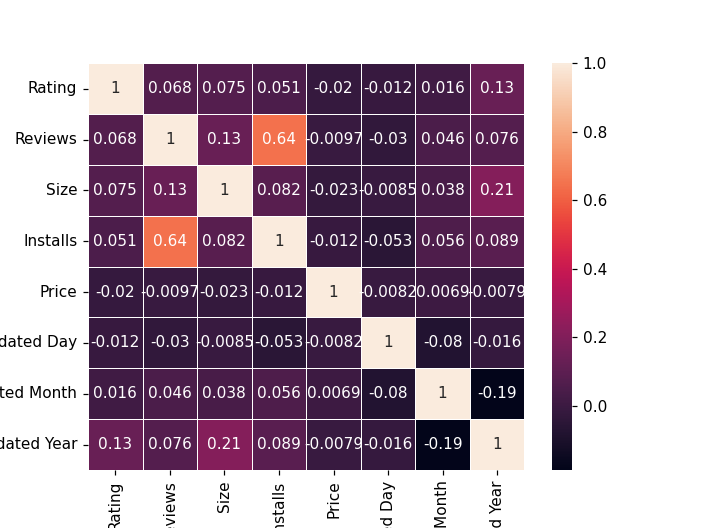

In [138]:
# Mirem la correlació entre els atributs del dataset
correlacio = dataset.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Observem que en aquest dataset les correlacions generalment són bastant baixes i cal tenir en compte que l'elevada correlació entre *Reviews* i *Size* es deu a que, evidentment, les persones que instal·len l'aplicació seràn també les que publiquin les ressenyes.

* La següent correlació més alta és la de *Type* amb *Price* i obté aquest valor perque quan una aplicacó és de tipus gratuïta té preu 0 i quan s'ha de pagar no, per tant tampoc és gens explicativa.

En aquest cas l'atribut sobre el que fem la predicció és ***Rating*** i veiem que té correlacions baixes amb tots els atributs. 